# GAMINet (Yang et al, 2021)

## Setup

In [1]:
#!nvidia-smi

In [1]:
!source ../ml-env/bin/activate

In [1]:
import wandb
%matplotlib inline

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from src.utils import normalize_target
from src.gaminet.gaminet import GAMINet
from src.gaminet.utils import local_visualize
from src.gaminet.utils import global_visualize_density
from src.gaminet.utils import global_visualize_wo_density
from src.gaminet.utils import feature_importance_visualize
from src.gaminet.utils import plot_regularization
from src.gaminet.utils import plot_trajectory

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### Setup multi-GPU training

In [4]:
#strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: %d' % strategy.num_replicas_in_sync)

In [2]:
wandb.login()
root_path ="./data/"
model_dir ="models/gaminet/"
subsample_name = "subsample_processed_unscaled.pkl"
fullsample_name = "data_processed_unscaled.pkl"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m-janyellow. Use `wandb login --relogin` to force relogin


## Data preprocessing and modelling methods

Note:

GAMINet takes one train/valid set and splits it internally for validation, which is why data_splitter returns four objects
(two for training/validation and two for testing respectively)

In [3]:
def data_splitter(X, y, end_of_training, end_of_test):
    """
    Parameters
    ------------
        end_of_training (str): Date that determines the last sample of training/validation set.
        end_of_test (str): Date that determines last test sample.
    """
    # define start of training
    start_of_training = X.index.get_level_values(0).min()
   
    # slice to required size
    X_train_val = X.loc[pd.IndexSlice[start_of_training:end_of_training,], :]
    y_train_val = y.loc[pd.IndexSlice[start_of_training:end_of_training,]]
    X_test = X.loc[pd.IndexSlice[end_of_training:end_of_test,], :]
    y_test = y.loc[pd.IndexSlice[end_of_training:end_of_test,]]
    
    return X_train_val, X_test, y_train_val, y_test

def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    return np.sqrt(np.mean((pred - label)**2))

def mse(label, pred, scaler):
    return mean_squared_error(label, pred)

def mae(label, pred, scaler):
    return mean_absolute_error(label, pred)

def load_regression_data(feature_selector=[], subsample=False, exclude_temporals=False,
                         exclude_months=False, end_of_training="1985-12-31", end_of_test="1990-12-31"):
    """
    Loads cleaned but unscaled data from data path, before scaling it and extracting some meta info, i.e.
    column names and data type (continuous/discrete). Finally, teh dataset is split train and test sets.
    """
    # get and prepare data
    if subsample:
        data = pd.read_pickle(root_path + subsample_name)
    else:
        data = pd.read_pickle(root_path + fullsample_name)
    
    if len(feature_selector) > 0:
        data = data.loc[:,feature_selector]

    # scale target
    scaler_y = StandardScaler()
    target = data.TARGET.values.reshape(-1, 1)
    data['TARGET'] = scaler_y.fit_transform(target)
    
    # isolate target from feature space
    x = data.iloc[:,:-1]
    y = data.TARGET
    
    # exclude temporal features
    if exclude_temporals:
        x.drop(columns=['yy','mm_sin', 'mm_cos'], inplace=True)
    
    if exclude_months:
        x.drop(columns=['mm_sin', 'mm_cos'], inplace=True)
    
    task_type = "Regression"
    meta_info = {x.columns[i]:{'type':'continuous'} for i in range(x.shape[1])}
    meta_info.update({'Y':{'type':'target'}})
    #xx = pd.DataFrame(np.zeros((x.shape[0], x.shape[1]), dtype=np.float32))
    # Min-Max Scale target and save scaler for evaluation
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            meta_info[key]['scaler'] = scaler_y
        else:
            scaler_x = MinMaxScaler((0, 1))
            #scaler_x.fit([[0], [1]])
            x[key] = scaler_x.fit_transform(x[key].values.reshape(-1, 1)) #(x.iloc[:,[i]])
            meta_info[key]['scaler'] = scaler_x
    train_x, test_x, train_y, test_y = data_splitter(x, y, end_of_training, end_of_test)
    train_x, test_x  = train_x.to_numpy(), test_x.to_numpy()
    train_y, test_y = train_y.to_numpy().reshape(-1,1), test_y.to_numpy().reshape(-1,1)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, scaler_y), metric_wrapper(mse, scaler_y), metric_wrapper(mae,scaler_y)

In [4]:
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = \
load_regression_data(subsample=True, end_of_training="1990-12-31", end_of_test="2014-05-31")

In [5]:
print(f"Max val of x: {train_x.max()}, Min x: {train_x.min()}")
print("Mean: ", train_x.mean())
print(f"Train data shape: {train_x.shape} \n Test data shape: {test_x.shape}")

Max val of x: 1.0000000000000002, Min x: 0.0
Mean:  0.29126620945278986
Train data shape: (87996, 67) 
 Test data shape: (127468, 67)


In [6]:
wandb.finish()


#### Cool ! Two things

1. Now, X is normalized between 0 and 1 and the scalers are saved to meta_info dictionary which enables denormalizing
back after training.
2. Using the argument exclude_temporals one can drop yy, mm_sin and mm_cos since training has shown that these models tend to overfit on temporal characteristics and Freyberger et al. do not use them either.

## Experiment
- all features
- full sample
- without temporal features
- pre-trained model

In [4]:
# load data
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = \
load_regression_data(exclude_temporals=True, subsample=False, end_of_training="1990-12-31", end_of_test="2014-05-31")

In [5]:
train_x.shape

(520442, 64)

In [21]:
# load model and pcik up training with it
model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[32] * 4, subnet_arch=[32] * 4, #50*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=30, interaction_epochs=20, tuning_epochs=20, #ep=5000
        lr_bp=[5e-5, 5e-5, 5e-5], early_stop_thres=[10, 10, 10],
        heredity=True, loss_threshold=0.01, reg_clarity=0.01,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')

# load model pre-trained on subset
model.load(folder=model_dir, name='140_model_interactions')

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 5, train loss: 0.75961, val loss: 0.77081
Main effects training epoch: 10, train loss: 0.75593, val loss: 0.76731
Model is being saved
Main effects training epoch: 15, train loss: 0.75572, val loss: 0.76718
Main effects training epoch: 20, train loss: 0.75577, val loss: 0.76734
Model is being saved
Early stop at epoch 21, with validation loss: 0.76722
##########Stage 1: main effect training stop.##########
##########Stage 2: interaction training start.##########
Interaction training epoch: 5, train loss: 0.75581, val loss: 0.76732
Early stop at epoch 7, with validation loss: 0.76732
##########Stage 2: interaction training stop.##########
Fine tuning epoch: 1, train loss: 0.75588, val loss: 0.76732
Fine tuning epoch: 2, train loss: 0.75584, val loss: 0.76736
Fine tuning epoch: 3, train loss: 0.75565, val loss: 0.76708
Fine tuning epoch: 4

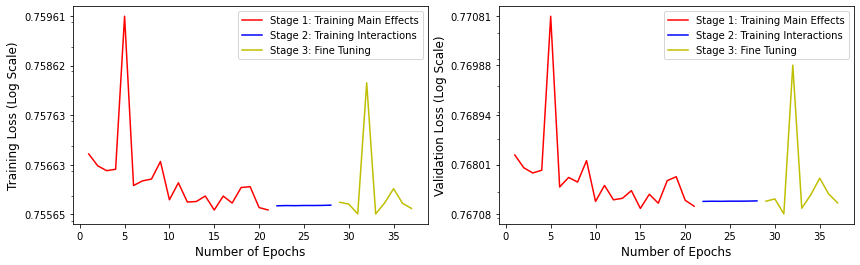

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


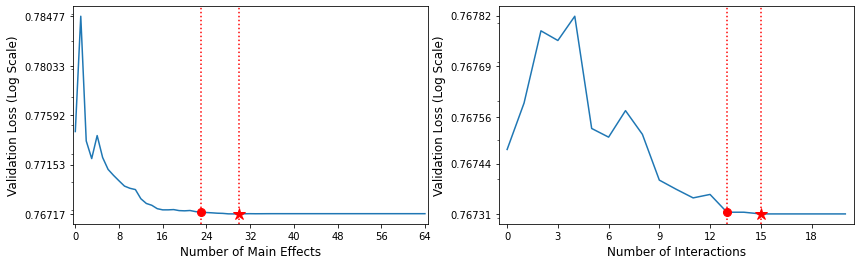

In [22]:
################## Training ###################
run_id = '14X'
folder = "./models/gaminet/"
if not os.path.exists(folder):
    os.makedirs(folder)

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

data_dict_logs = model.summary_logs(save_dict=True, folder=model_dir, name=f"{run_id}_summary_logs")
plot_trajectory(data_dict_logs, folder=folder, name=f"{run_id}_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name=f"{run_id}_regu", save_png=True, save_eps=True)

In [25]:
model.save(folder=model_dir, name="147_model_finetuning.pickle")

In [31]:
len(data_dict['ret']['outputs'])

100

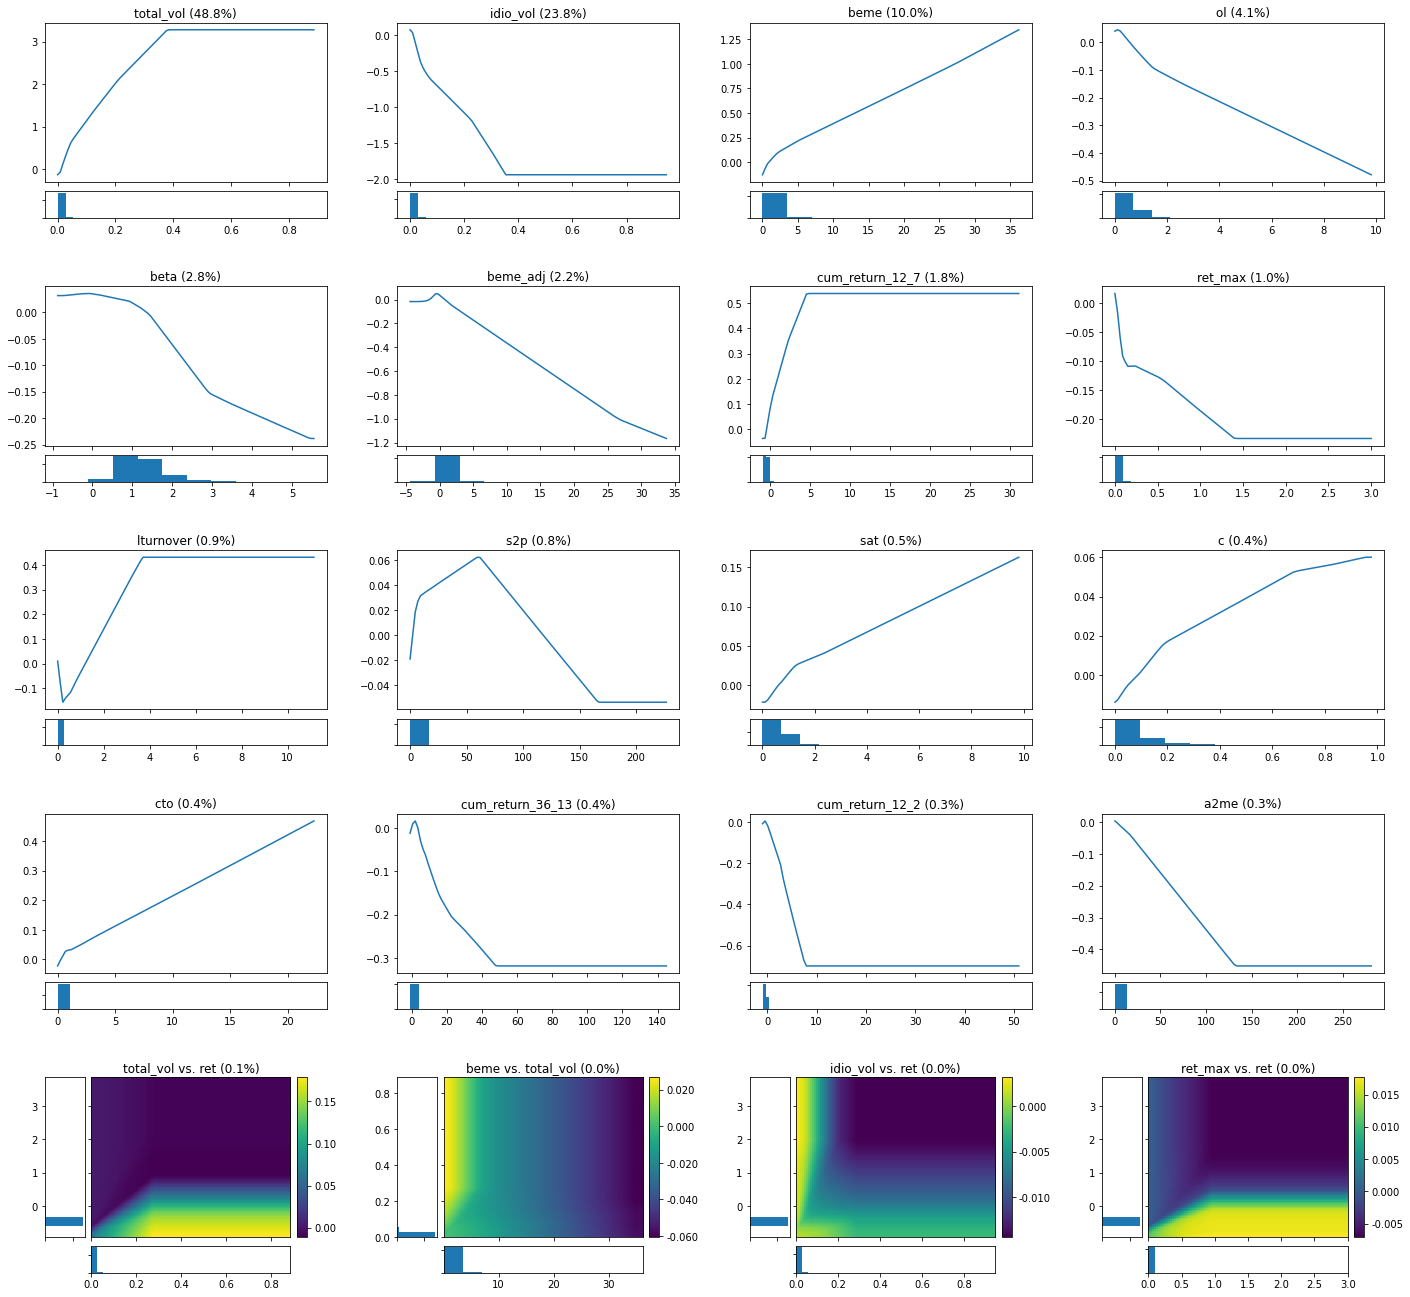

In [26]:
# plot explanations
data_dict = model.global_explain(save_dict=True)
global_visualize_density(data_dict, save_png=True, folder=folder, name=f'{run_id}global_top20', main_effect_num=16, interaction_num=4)

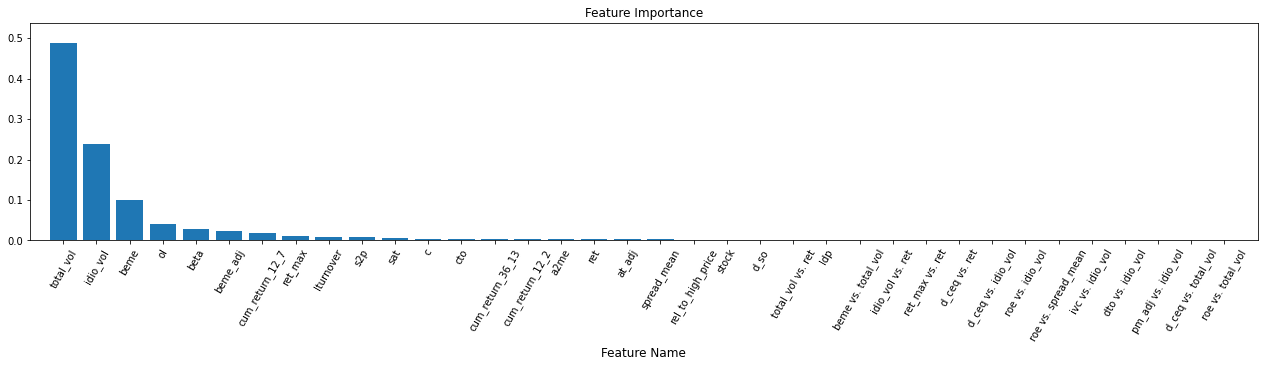

In [24]:
feature_importance_visualize(data_dict, save_png=True)

In [9]:
#import wandb
wandb.finish()

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,▁▁▂▁▁▂▁▁▂▁▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▄█▃▃
Train Loss,▂▂▂▁▁▂▁▁▃▁▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▄█▄▃
max_epochs,▁
n_features,▁
Loss test:,0.76719
Train Loss,0.75532
max_epochs,1200
n_features,64



## Experiment

- use normalized features (67 independant, 1 dependant)
- and without shuffling for valid. -> was horrible
- tried again with shuffling yielded way better performance

In [7]:
# load model and pcik up training with it
model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[32] * 4, subnet_arch=[32] * 4, #50*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=600, interaction_epochs=600, tuning_epochs=300, #ep=5000
        lr_bp=[5e-5, 5e-5, 5e-5], early_stop_thres=[50, 40, 40],
        heredity=True, loss_threshold=0.01, reg_clarity=0.01,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')

model.load(folder=model_dir, name='138_model_interactions')

2022-08-30 19:16:54.582797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 19:16:57.358274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30981 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2022-08-30 19:16:57.359170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30981 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


In [8]:
model.maineffect_blocks.weights # weights were stored too, yay!

[<tf.Variable 'gami_net_1/main_effect_block_1/numer_net_67/dense_402/kernel:0' shape=(1, 32) dtype=float32, numpy=
 array([[-0.32513368, -0.02010036, -0.15238225,  0.24370088,  0.11519785,
          0.33407277,  0.19462726, -0.09908845, -0.10961251,  0.24420717,
         -0.10114551, -0.3484103 ,  0.00345809,  0.24530756, -0.10235383,
         -0.23484752, -0.22119679, -0.16264355,  0.00428943,  0.10850378,
          0.13313137, -0.00956595, -0.22996263, -0.01875255,  0.43253484,
          0.01868985, -0.00447253,  0.03292943,  0.12489017, -0.46036145,
         -0.06165202,  0.29198718]], dtype=float32)>,
 <tf.Variable 'gami_net_1/main_effect_block_1/numer_net_67/dense_402/bias:0' shape=(32,) dtype=float32, numpy=
 array([ 0.        ,  0.        ,  0.        , -0.00254709, -0.00194724,
        -0.00115474, -0.00594797,  0.        ,  0.        , -0.00200263,
         0.        ,  0.        , -0.00046387, -0.00448334,  0.        ,
         0.        ,  0.        ,  0.        , -0.0005587

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 5, train loss: 0.73168, val loss: 0.73602
Main effects training epoch: 10, train loss: 0.73126, val loss: 0.73588
Model is being saved
Main effects training epoch: 15, train loss: 0.73104, val loss: 0.73569
Main effects training epoch: 20, train loss: 0.73097, val loss: 0.73550
Model is being saved
Main effects training epoch: 25, train loss: 0.73090, val loss: 0.73547
Main effects training epoch: 30, train loss: 0.73076, val loss: 0.73551
Model is being saved
Main effects training epoch: 35, train loss: 0.73079, val loss: 0.73549
Main effects training epoch: 40, train loss: 0.73117, val loss: 0.73570
Model is being saved
Main effects training epoch: 45, train loss: 0.73053, val loss: 0.73542
Main effects training epoch: 50, train loss: 0.73064, val loss: 0.73544
Model is being saved
Main effects training epoch: 55, train loss: 0.73038, 

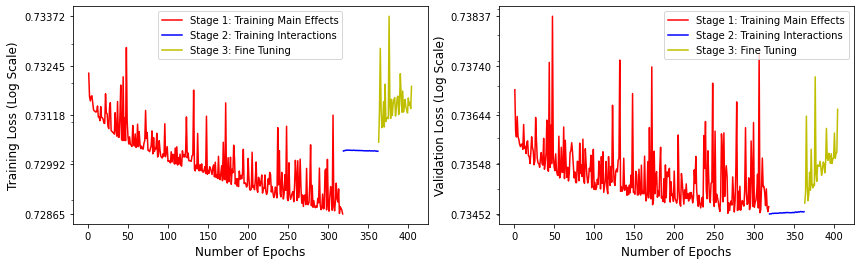

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


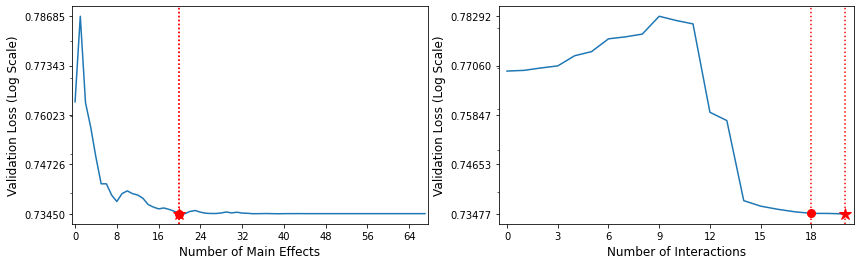

In [9]:
################## Training ###################
run_id = '139'
folder = "./models/gaminet/"
if not os.path.exists(folder):
    os.makedirs(folder)

#### skip for training on loaded model ---> kinda transfer learning
# model = GAMINet(meta_info=meta_info, interact_num=20,
#         interact_arch=[32] * 4, subnet_arch=[32] * 4, #50*5
#         batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
#         main_effect_epochs=600, interaction_epochs=600, tuning_epochs=300, #ep=5000
#         lr_bp=[5e-5, 5e-5, 5e-5], early_stop_thres=[50, 40, 40],
#         heredity=True, loss_threshold=0.01, reg_clarity=0.01,
#         verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

data_dict_logs = model.summary_logs(save_dict=True, folder=model_dir, name=f"{run_id}_summary_logs")
plot_trajectory(data_dict_logs, folder=folder, name=f"{run_id}_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name=f"{run_id}_regu", save_png=True, save_eps=True)

In [8]:
wandb.finish()

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,██▆▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁
Train Loss,██▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
max_epochs,▁
n_features,▁
Loss test:,0.7705
Train Loss,0.77339
max_epochs,1200
n_features,67


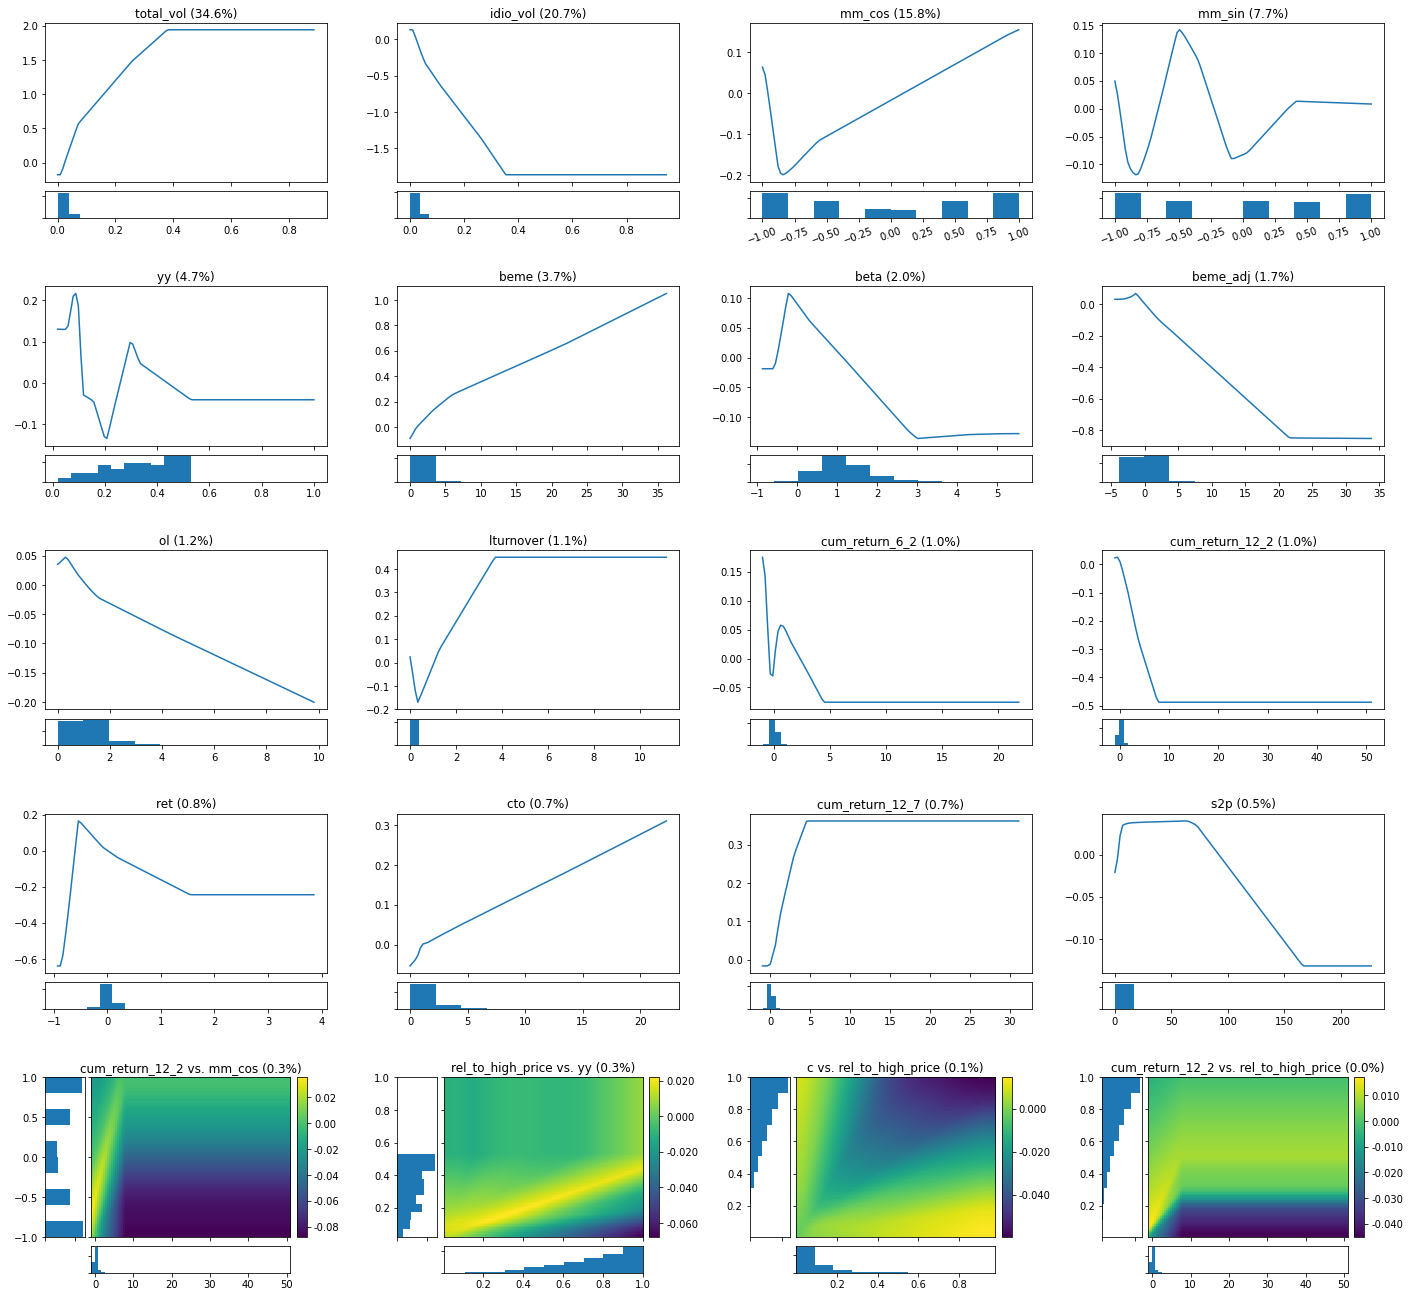

In [11]:
# is there anything to explain?
run_id = '139'
data_dict = model.global_explain(save_dict=True)
global_visualize_density(data_dict, save_png=True, folder=model_dir, name=f'{run_id}_global_top20', main_effect_num=16, interaction_num=4)

In [12]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_rmse = np.hstack([np.round(get_rmse(train_y, pred_train),5),
                      np.round(get_rmse(test_y, pred_test),5)])
gaminet_mse = np.hstack([np.round(get_mse(train_y, pred_train),5),
                      np.round(get_mse(test_y, pred_test),5)])
gaminet_mae = np.hstack([np.round(get_mae(train_y, pred_train),5),
                      np.round(get_mae(test_y, pred_test),5)])

wandb.log({"rmse_train" : gaminet_rmse[0], "rmse_test" : gaminet_rmse[1],
           "mse_train" : gaminet_mse[0], "mse_test" : gaminet_mse[1],
           "mae_train" : gaminet_mae[0], "mae_test" : gaminet_mae[1]
           })
wandb.finish()

rmse_train = gaminet_rmse[0]
rmse_test = gaminet_rmse[1]
mse_train = gaminet_mse[0]
mse_test = gaminet_mse[1]
mae_train = gaminet_mae[0]
mae_test = gaminet_mae[1]

print('----------- Train performance------------ \n MAE :', mae_train,'\n MSE: ', mse_train, '\n RMSE: ', rmse_train)
print('----------- Test performance------------ \n MAE :', mae_test,'\n MSE: ', mse_test, '\n RMSE: ', rmse_test)

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,▅▅▄▃█▄▄▄▃▄▃▂▃▂▂▃▂▂▂▂▁▂▂▁▇▄▂▂▂▁▁▁▁▁▁▁▂▃▃▆
Train Loss,▇▆▆▅█▅▅▆▄▆▄▃▄▃▃▃▃▃▂▂▂▂▃▂▅▃▂▂▁▁▁▄▄▄▄▄▆▆▆▇
mae_test,▁
mae_train,▁
max_epochs,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
Loss test:,0.73655


----------- Train performance------------ 
 MAE : 0.6175 
 MSE:  0.76808 
 RMSE:  0.8764
----------- Test performance------------ 
 MAE : 0.69838 
 MSE:  1.17158 
 RMSE:  1.0824


## Experiment:

- no temporal features, which results in 64 instead of 67 features for training

In [13]:
# Get the data
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = \
load_regression_data(subsample=True, end_of_training="1990-12-31", end_of_test="2014-05-31",
                    exclude_temporals=True)

print(f"Max val of x: {train_x.max()}, Min x: {train_x.min()}")
print("Mean: ", train_x.mean())
print(f"Train data shape: {train_x.shape} \n Test data shape: {test_x.shape}")

Max val of x: 1.0000000000000002, Min x: 0.0
Mean:  0.2843977104221025
Train data shape: (87996, 64) 
 Test data shape: (127468, 64)


####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 5, train loss: 0.79447, val loss: 0.78759
Main effects training epoch: 10, train loss: 0.79355, val loss: 0.78680
Model is being saved
Main effects training epoch: 15, train loss: 0.79242, val loss: 0.78607
Main effects training epoch: 20, train loss: 0.79190, val loss: 0.78566
Model is being saved
Main effects training epoch: 25, train loss: 0.79164, val loss: 0.78566
Main effects training epoch: 30, train loss: 0.79124, val loss: 0.78505
Model is being saved
Main effects training epoch: 35, train loss: 0.79092, val loss: 0.78480
Main effects training epoch: 40, train loss: 0.79097, val loss: 0.78458
Model is being saved
Main effects training epoch: 45, train loss: 0.79042, val loss: 0.78439
Main effects training epoch: 50, train loss: 0.79023, val loss: 0.78409
Model is being saved
Main effects training epoch: 55, train loss: 0.79055, 

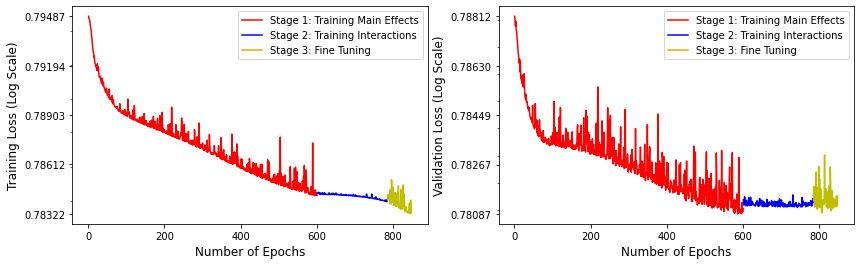

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


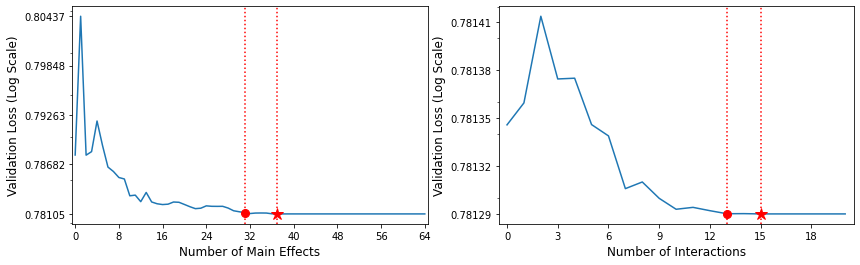

In [14]:
################## Training ###################
run_id = '140'
folder = "./models/gaminet/"
if not os.path.exists(folder):
    os.makedirs(folder)

model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[32] * 4, subnet_arch=[32] * 4, #50*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=600, interaction_epochs=600, tuning_epochs=300, #ep=5000
        lr_bp=[5e-5, 5e-5, 5e-5], early_stop_thres=[50, 40, 40],
        heredity=True, loss_threshold=0.01, reg_clarity=0.01,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

data_dict_logs = model.summary_logs(save_dict=True, folder=model_dir, name=f"{run_id}_summary_logs")
plot_trajectory(data_dict_logs, folder=folder, name=f"{run_id}_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name=f"{run_id}_regu", save_png=True, save_eps=True)

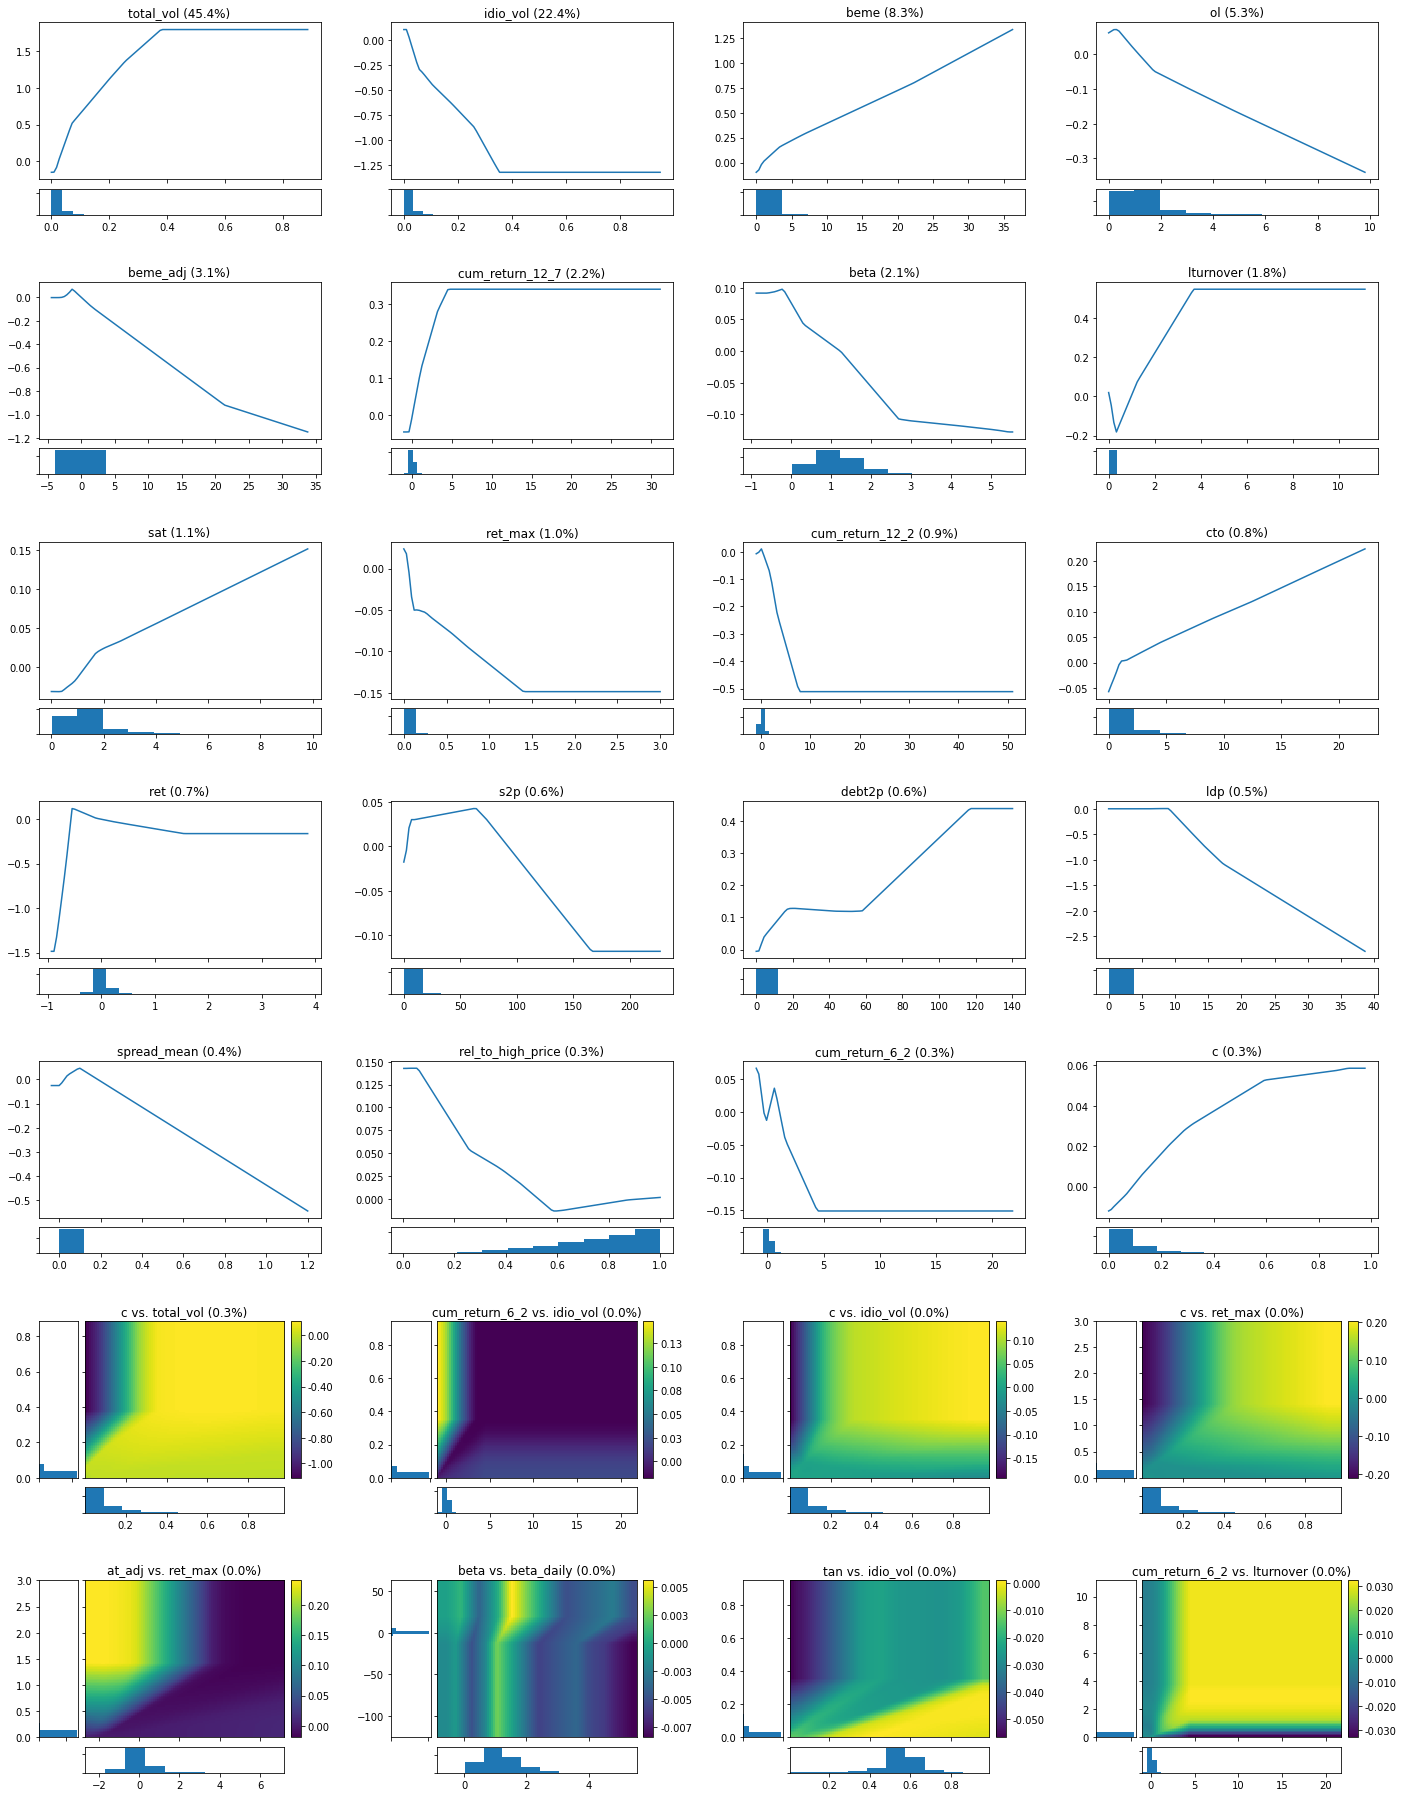

In [20]:
# Plot explanations
run_id = '140'
data_dict = model.global_explain(save_dict=True)
global_visualize_density(data_dict, save_png=True, folder=model_dir, name=f'{run_id}_global', main_effect_num=20, interaction_num=8)

In [19]:
# feat impportances of run 140 - no temps
data_dict_140 = np.load(model_dir+'140_global_explain_dict.npy', allow_pickle=True)
#feature_importance_visualize(data_dict_140, save_png=True)

TypeError: iteration over a 0-d array

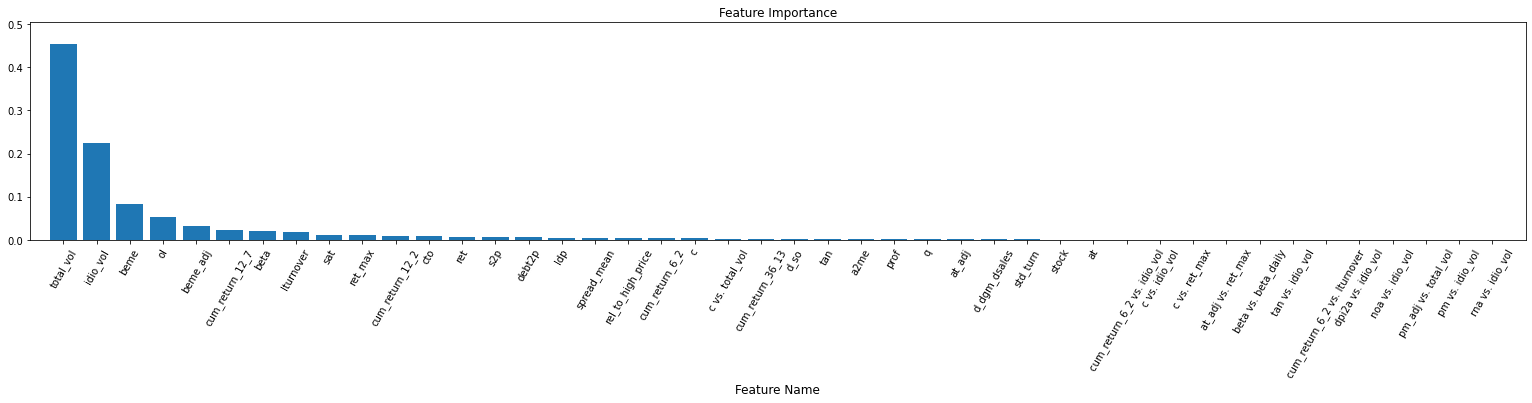

In [19]:
# feature importance plot
feature_importance_visualize(data_dict, save_png=False)

In [16]:
# evaluate and finish training run
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_rmse = np.hstack([np.round(get_rmse(train_y, pred_train),5),
                      np.round(get_rmse(test_y, pred_test),5)])
gaminet_mse = np.hstack([np.round(get_mse(train_y, pred_train),5),
                      np.round(get_mse(test_y, pred_test),5)])
gaminet_mae = np.hstack([np.round(get_mae(train_y, pred_train),5),
                      np.round(get_mae(test_y, pred_test),5)])

wandb.log({"rmse_train" : gaminet_rmse[0], "rmse_test" : gaminet_rmse[1],
           "mse_train" : gaminet_mse[0], "mse_test" : gaminet_mse[1],
           "mae_train" : gaminet_mae[0], "mae_test" : gaminet_mae[1]
           })
wandb.finish()

rmse_train = gaminet_rmse[0]
rmse_test = gaminet_rmse[1]
mse_train = gaminet_mse[0]
mse_test = gaminet_mse[1]
mae_train = gaminet_mae[0]
mae_test = gaminet_mae[1]

print('----------- Train performance------------ \n MAE :', mae_train,'\n MSE: ', mse_train, '\n RMSE: ', rmse_train)
print('----------- Test performance------------ \n MAE :', mae_test,'\n MSE: ', mse_test, '\n RMSE: ', rmse_test)

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,█▆▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▁▂▁▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂
Train Loss,█▇▆▅▅▅▄▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
mae_test,▁
mae_train,▁
max_epochs,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
Loss test:,0.78153


----------- Train performance------------ 
 MAE : 0.62291 
 MSE:  0.78294 
 RMSE:  0.88484
----------- Test performance------------ 
 MAE : 0.69098 
 MSE:  1.16273 
 RMSE:  1.0783


## Experiment:
- using all features (standardized)

In [14]:
# load preselected data
train_x, test_x, train_y, test_y, task_type, meta_info, get_rmse, get_mse, get_mae = load_regression_data(subsample=True)

InvalidIndexError: (slice(None, None, None), [0])

In [5]:
print(f"Size of train set: {train_x.shape}, \n Test set {test_x.shape}")

Size of train set: (64502, 67), 
 Test set (26273, 67)


In [19]:
################## Training ###################
folder = "./models/gaminet/"
if not os.path.exists(folder):
    os.makedirs(folder)

#with strategy.scope():
model = GAMINet(meta_info=meta_info, interact_num=20,
        interact_arch=[40] * 4, subnet_arch=[40] * 4, #*5
        batch_size=256, task_type=task_type, activation_func=tf.nn.relu, # batch=200
        main_effect_epochs=500, interaction_epochs=500, tuning_epochs=250, #ep=5000
        lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
        heredity=True, loss_threshold=0.01, reg_clarity=0.1,
        verbose=True, val_ratio=0.2, random_state=0, model_dir='./models/gaminet/')# , strategy=strategy)

# initialize wandb
wandb.init(project="interpretable-ml", group="gaminet-studies")
wandb.log({"learning_rate" : model.lr_bp, "max_epochs" : model.main_effect_epochs+model.interaction_epochs,
#           #"optimizer" : model.optimizer, 
           "n_features" : train_x.shape[1],
           #"loss_function" : model.loss_fn
           })

model.fit(train_x, train_y)

#wandb.log_artifact(model)

#wandb.log({
           #"maineffect train loss" : model.err_train_main_effect_training [-1],
           #"maineffect val loss" : model.err_val_main_effect_training[-1],
           #"interaction train loss" : model.err_train_interaction_training[-1],
           #"interaction val loss" : model.err_val_interaction_training[-1],
           #"Fine tuning train loss" : model.err_train_tuning[-1],
           #"Fine tuning val loss" : model.err_val_tuning[-1]
#})

data_dict_logs = model.summary_logs(save_dict=True)
plot_trajectory(data_dict_logs, folder=folder, name="125_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="125_regu", save_png=True, save_eps=True)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.73367, val loss: 0.73837
Main effects training epoch: 6, train loss: 0.72498, val loss: 0.73022
Model is being saved
Main effects training epoch: 11, train loss: 0.72151, val loss: 0.72683
Main effects training epoch: 16, train loss: 0.71837, val loss: 0.72401
Model is being saved
Main effects training epoch: 21, train loss: 0.71601, val loss: 0.72222
Main effects training epoch: 26, train loss: 0.71453, val loss: 0.72127
Model is being saved
Main effects training epoch: 31, train loss: 0.71302, val loss: 0.72064
Main effects training epoch: 36, train loss: 0.71152, val loss: 0.71898
Model is being saved
Main effects training epoch: 41, train loss: 0.71075, val loss: 0.71902
Main effects training epoch: 46, train loss: 0.71052, val loss: 0.71902
Model is being saved
Main effects training epoch: 51, train loss: 0.70838, v

NameError: name 'batch_train_loss' is not defined

In [20]:
# save model summary log
data_dict_logs = model.summary_logs(save_dict=True, folder='models/gaminet/', name='summary_logs_133')

In [15]:
prev_model = pd.read_pickle('models/gaminet/model_interactions.pkl')

In [38]:
# this was an attempt to see the features ranked by importance...
idx = prev_model['active_main_effect_index']
feature_dict = list(meta_info.keys())
print("Main effect importance :", feature_dict[idx])

TypeError: only integer scalar arrays can be converted to a scalar index

## Final model evaluation and interpretability

In [21]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
gaminet_rmse = np.hstack([np.round(get_rmse(train_y, pred_train),5),
                      np.round(get_rmse(test_y, pred_test),5)])
gaminet_mse = np.hstack([np.round(get_mse(train_y, pred_train),5),
                      np.round(get_mse(test_y, pred_test),5)])
gaminet_mae = np.hstack([np.round(get_mae(train_y, pred_train),5),
                      np.round(get_mae(test_y, pred_test),5)])

wandb.log({"rmse_train" : gaminet_rmse[0], "rmse_test" : gaminet_rmse[1],
           "mse_train" : gaminet_mse[0], "mse_test" : gaminet_mse[1],
           "mae_train" : gaminet_mae[0], "mae_test" : gaminet_mae[1]
           })
wandb.finish()

rmse_train = gaminet_rmse[0]
rmse_test = gaminet_rmse[1]
mse_train = gaminet_mse[0]
mse_test = gaminet_mse[1]
mae_train = gaminet_mae[0]
mae_test = gaminet_mae[1]

print('----------- Train performance------------ \n MAE :', mae_train,'\n MSE: ', mse_train, '\n RMSE: ', rmse_train)
print('----------- Test performance------------ \n MAE :', mae_test,'\n MSE: ', mse_test, '\n RMSE: ', rmse_test)

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Loss test:,█▇▇▇▇▇▇▇▇▇▇▆▅▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,██▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
mae_test,▁
mae_train,▁
max_epochs,▁
mse_test,▁
mse_train,▁
n_features,▁
rmse_test,▁
rmse_train,▁
Loss test:,0.63538


----------- Train performance------------ 
 MAE : 0.55903 
 MSE:  0.60794 
 RMSE:  0.7797
----------- Test performance------------ 
 MAE : 0.65427 
 MSE:  0.89823 
 RMSE:  0.94775


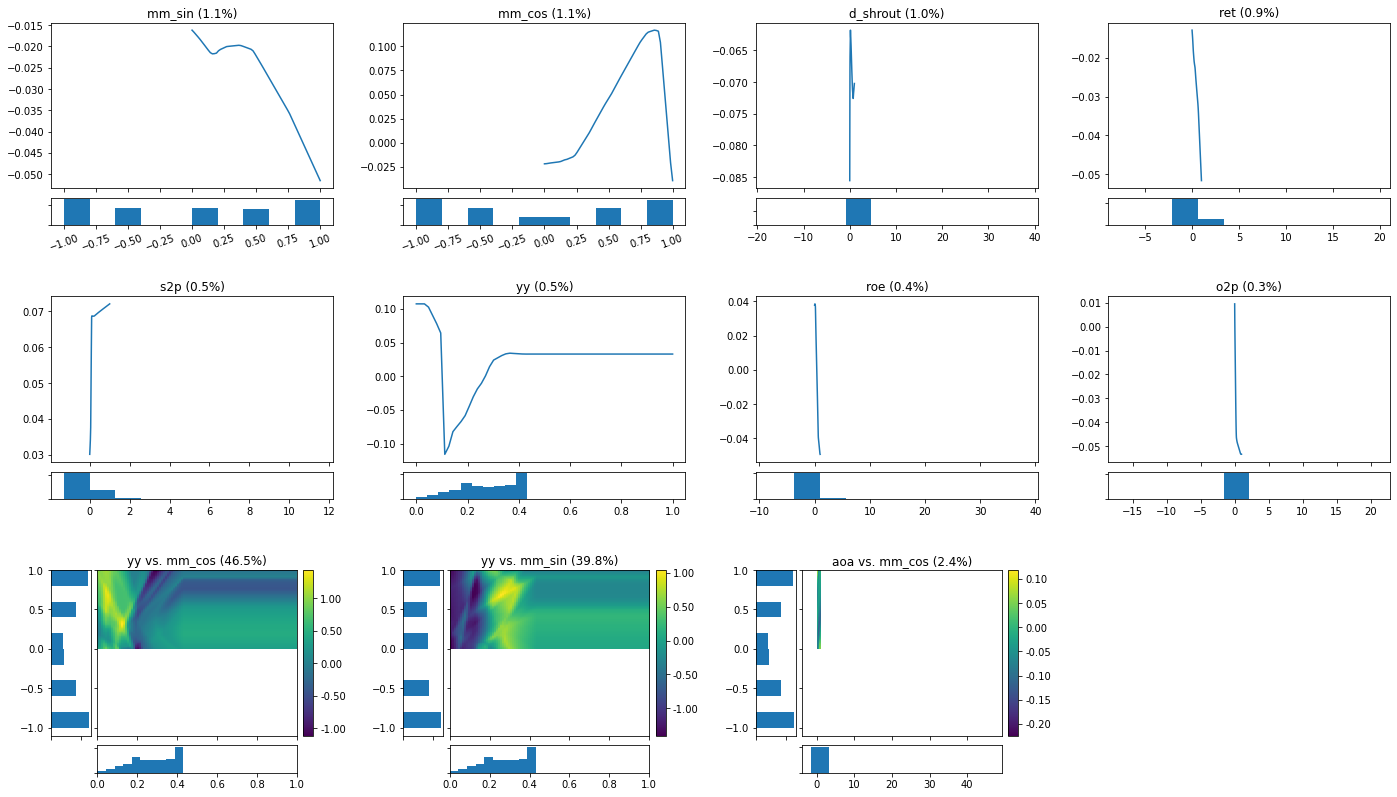

In [28]:
# Plot global explanations
# TO-DO: play around with global_explain's main_grid_size and interact_grid_size arguemnts!
data_dict_global = model.global_explain(save_dict=False, folder=folder, name="explain_global", main_grid_size=64)
global_visualize_density(data_dict_global, folder=folder, name="explain_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=False, save_eps=False)

In [40]:
data_dict_global

{'cum_return_1_0': {'density': {'names': array([-7.54969498, -4.82270924, -2.0957235 ,  0.63126224,  3.35824798,
           6.08523372,  8.81221946, 11.5392052 , 14.26619094, 16.99317668,
          19.72016242]),
   'scores': array([4.97458728e-05, 3.62434216e-03, 2.89222504e-01, 7.18969993e-02,
          1.69846623e-03, 1.77663831e-04, 2.84262130e-05, 0.00000000e+00,
          0.00000000e+00, 7.10655325e-06])},
  'type': 'continuous',
  'importance': 0.0,
  'inputs': array([0.        , 0.01587302, 0.03174603, 0.04761905, 0.06349206,
         0.07936508, 0.0952381 , 0.11111111, 0.12698413, 0.14285714,
         0.15873016, 0.17460317, 0.19047619, 0.20634921, 0.22222222,
         0.23809524, 0.25396825, 0.26984127, 0.28571429, 0.3015873 ,
         0.31746032, 0.33333333, 0.34920635, 0.36507937, 0.38095238,
         0.3968254 , 0.41269841, 0.42857143, 0.44444444, 0.46031746,
         0.47619048, 0.49206349, 0.50793651, 0.52380952, 0.53968254,
         0.55555556, 0.57142857, 0.58730159, 0

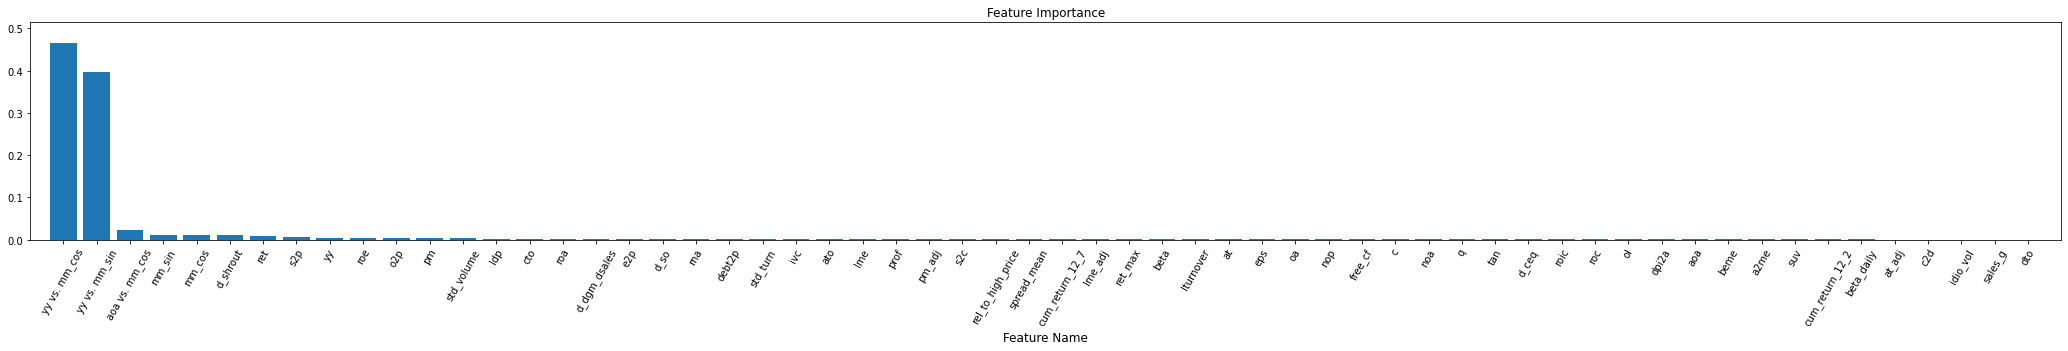

In [26]:
# feature importance plot

feature_importance_visualize(data_dict_global, save_png=False)

In [ ]:
## attempt to reduce importance plot (failed)

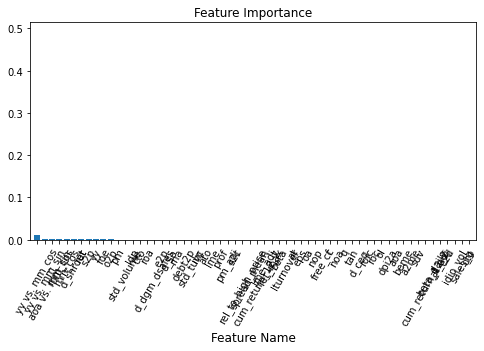

In [57]:
import matplotlib.pyplot as plt
all_ir = []
all_names = []
n = 11 # number features to show +1

for key, item in data_dict_global.items():
    if item["importance"] > 0:
        all_ir.append(item["importance"])
        all_names.append(key)

max_ids = len(all_names)
if max_ids > 0:
    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes()
    ax.bar(np.arange(len(all_ir[:n])), [ir for ir, _ in sorted(zip(all_ir[:n], all_names[:n]))][::-1])
    ax.set_xticks(np.arange(len(all_ir)))
    ax.set_xticklabels([name for _, name in sorted(zip(all_ir, all_names))][::-1], rotation=60)
    plt.xlabel("Feature Name", fontsize=12)
    plt.ylim(0, np.max(all_ir) + 0.05)
    plt.xlim(-1, len(all_names))
    plt.title("Feature Importance")

In [46]:
sorted_ir

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 [0.010035923701060207,
  0.0023005333004599694,
  0.0021635694287134894,
  0.0016410015929911909,
  0.0015229718421997031,
  0.001074197098615628,
  0.000868273760061787,
  0.0007685875271114591,
  0.0006966984746886025,
  0.000548714822607,
  0.0004075093525633262])

In [24]:
# local explanations
data_dict_local = model.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/slurm_tmpdir/job_21023063/ipykernel_1371635/2091408025.py", line 2, in <cell line: 2>
    data_dict_local = model.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
  File "/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/gaminet/gaminet.py", line 864, in local_explain
  File "/pfs/data5/home/kit/stud/uvnyg/seminar-interpretable-ml/src/gaminet/gaminet.py", line 864, in <listcomp>
AttributeError: 'GAMINet' object has no attribute 'active_indice'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.struc

### Custom global explain w/ Standard Scaled Features

In [31]:
import pickle
with open('data/rank_standard_scaler_x.pkl', 'rb') as f:
    scaler_x = pickle.load(f)
scaler_x

/opt/bwhpc/common/jupyter/tensorflow/2022-03-30/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


date
1963-07-31    StandardScaler()
1963-08-31    StandardScaler()
1963-09-30    StandardScaler()
1963-10-31    StandardScaler()
1963-11-30    StandardScaler()
                    ...       
2013-12-31    StandardScaler()
2014-01-31    StandardScaler()
2014-02-28    StandardScaler()
2014-03-31    StandardScaler()
2014-04-30    StandardScaler()
Length: 610, dtype: object

In [36]:
scaler_x[0].inverse_transform(np.array([1,2]).reshape(1,-1))
# scaler has been saved before some features were removed! Check again in preprocessing notbeook

ValueError: operands could not be broadcast together with shapes (1,2) (78,) (1,2) 

In [9]:
import pickle
model_dir = 'models/gaminet/'

with open(model_dir + 'model_interactions_133.pickle', 'rb') as f:
    model_dict = pickle.load(f)

In [11]:
model_dict.keys()

dict_keys(['meta_info', 'main_effect_weights', 'interaction_weights', 'err_train_main_effect_training', 'err_val_main_effect_training', 'err_train_interaction_training', 'err_val_interaction_training', 'err_train_tuning', 'err_val_tuning', 'interaction_list', 'main_effect_val_loss', 'interaction_val_loss', 'active_main_effect_index', 'active_interaction_index'])

## Feature selection 

In [7]:
## best features used by freyberger et al:
#features_freyberger = ['d_shrout', 'd_so', 'investment', 'lme', 'lturnover', 'pm_adj', 'cum_return_1_0',\
#'cum_return_12_2', 'cum_return_12_7', 'rel_to_high_price', 'roc', 'stock','suv', 'total_vol','TARGET']

## best features found by random forrest reg
#features_rf = ['d_shrout', 'roe', 'oa', 'free_cf', 'nop', 'dpi2a', 'rna', 'ato', 'd_dgm_dsales', 'roc', 'ipm', 'spread_mean', 'dto', 'suv', 'TARGET']

#features_ae = ['e2p', 'beme', 'cum_return_12_2', 'cum_return_12_7', 'mm_sin', 'mm_cos', 'yy', 'dpi2a', 'ret', 'total_vol', 'noa', 'std_volume', 'cto', 'TARGET']

